In [646]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [647]:
root_path = "/Users/leonardomassaro/Desktop/dataset_books/"

### Function definition: display grid images

In [648]:

def display_image_grid(images, total_size=(10, 10), ncols=None, show_axes=False):
    """
    Display a grid of images using matplotlib, preserving aspect ratios.

    Parameters
    ----------
    images : list
        List of image arrays (e.g., from PIL.Image or matplotlib.image.imread()).
    total_size : tuple (width, height)
        Total size of the display area in inches (figure size).
    ncols : int, optional
        Number of columns. If None, it is automatically chosen to form a near-square grid.
    show_axes : bool
        Whether to display axes ticks and labels.
    """
    num_images = len(images)
    if num_images == 0:
        raise ValueError("The image list is empty.")

    # Auto-determine number of columns and rows
    if ncols is None:
        ncols = math.ceil(math.sqrt(num_images))
    nrows = math.ceil(num_images / ncols)

    # Create figure
    fig, axes = plt.subplots(nrows, ncols, figsize=total_size,
                             constrained_layout=True)

    # Flatten axes array for easy iteration
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_images:
            img = images[i]
            ax.imshow(img, aspect='equal', cmap='gray')  # Preserve each image's aspect ratio
            if not show_axes:
                ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots

    plt.show()

### Function definition: cropping model images borders

In [649]:
def cut_out_borders(image, vertical_percentage:int, horizontal_percentage):
    '''
    Cut out border portions of the image

    Parameters
    ----------
    image: image to crop
    percentage: portion to be cut out from each side of the image (top, right, bottom, left)
    '''
    if vertical_percentage >= 50 or horizontal_percentage >= 50:
        raise Exception("Percentage must be lower than 50%")
    cut_x, cut_y = int((image.shape[0]/100)*horizontal_percentage), int((image.shape[1]/100)*vertical_percentage)
    return image[cut_y:-cut_y-1, cut_x:-cut_x-1 ]

### Function definition: edge detection for RGB

In [650]:
def edge_on_rgb(image_rgb, params):
    THRESH1, THRESH2 = params["thresh1_canny"], params["thresh2_canny"]
    D = params["bilat_filter_d"]
    SIGMA_COLOR, SIGMA_SPACE = params["bilat_sigma_col"], params["bilat_sigma_space"]
    bilateral_filtered = cv2.Canny(cv2.bilateralFilter(image_rgb, d=D, sigmaColor=SIGMA_COLOR, sigmaSpace=SIGMA_SPACE), THRESH1, THRESH2)

    return bilateral_filtered

### Function definition: expand edges in scenes

In [ ]:
def expand_edges_scenes(edge_image, params):
    if params["expand_edges_isActive"]:
        STRUCT_ELEM_SHAPE = params["structuring_elem_shape"]
        KERNEL = params["kernel_struct_elem"]
        MORPH_MODE = params["morph_mode"]
        kernel = cv2.getStructuringElement(STRUCT_ELEM_SHAPE, KERNEL)
        closed = cv2.morphologyEx(edge_image, MORPH_MODE, kernel)
        return closed
    else:
        return edge_image

### Function definition: connected region selection -- add and try parameters for filling

In [ ]:

def extract_connected_regions(image, points, connectivity=4):
    """
    Given an edge-detected image and a list of seed points,
    returns a mask for each connected region that shares the same color
    as the seed point (using flood fill or connected components).

    Args:
        image (np.ndarray): Input image (grayscale or binary).
        points (list of tuples): List of (x, y) seed points.
        connectivity (int): 4 or 8 connectivity for region growing.

    Returns:
        regions (list of np.ndarray): List of binary masks, one per point.
    """
    points = points.tolist()
    h, w = image.shape
    tot_mask = image - image

    # Keep track of processed pixels to avoid overlaps
    processed = np.zeros_like(image, dtype=np.uint8)

    for i, (x, y) in enumerate(points):
        if x < 0 or y < 0 or x >= w or y >= h:
            print(f"Skipping invalid point {x, y}")
            continue

        target_value = image[y, x]

        # Skip if already processed
        if processed[y, x]:
            continue

        #if it is on the edge do not consider
        if target_value != 0:
            mask = np.zeros((h + 2, w + 2), np.uint8)
            mask[y,x] = 255
        else:
            # Flood fill to get connected region
            mask = np.zeros((h + 2, w + 2), np.uint8)
            _, _, _, rect = cv2.floodFill(
                image.copy(), mask, (x, y),
                newVal=255,
                loDiff=0, upDiff=0,
                flags=connectivity | (255 << 8)
            )

        # Flood-filled mask (remove 1px border added by OpenCV)
        region_mask = (mask[1:-1, 1:-1] > 0).astype(np.uint8)

        # Update processed
        processed = cv2.bitwise_or(processed, region_mask)

        tot_mask = cv2.bitwise_or(tot_mask, region_mask)

    return tot_mask

### Function definition: get bounding box given selected regions

In [653]:
def get_bounding_box_from_mask(mask):
    mask = (mask > 0).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    # Combine all contours to get the overall region
    cnt = np.vstack(contours)

    # Get min-area rectangle
    rect = cv2.minAreaRect(cnt)
    (cx, cy), (w, h), angle = rect
    (cx, cy), (w, h), angle = (cx, cy), (w, h), angle


    # Convert to 4 corner points
    box_points = cv2.boxPoints(rect)
    box_points = np.int64(box_points)

    return box_points, rect

### Function definition: Compute sift descriptors for models and scenes (wrap this in a function (parametric))

In [654]:
def compute_sift(models, scenes, scenes_grayscale, params):
    SIGMA = params["sift_sigma"]
    OCT_LYRS = params["sift_oct_layers"]
    CONTRAST_THRESH = params["sift_contrast_thresh"]
    EDGE_THRESH = params["sift_edge_thresh"]
    
    sift = cv2.SIFT_create(sigma=SIGMA, nOctaveLayers=OCT_LYRS, contrastThreshold=CONTRAST_THRESH, edgeThreshold=EDGE_THRESH)

    models_kp_des = {}  # dict: idx -> {img, kp, des}
    for i, img in enumerate(models):
        if img is None:
            models_kp_des[i] = {'img': None, 'kp': None, 'des': None}
            continue
        kp, des = sift.detectAndCompute(img, None)
        models_kp_des[i] = {'img': img, 'kp': np.array(kp), 'des': np.array(des)}

    scenes_kp_des = {}  # dict: idx -> {img_color, img_gray, kp, des}
    for i, (img_color, img_gray) in enumerate(zip(scenes, scenes_grayscale)):
        if img_gray is None or img_color is None:
            scenes_kp_des[i] = {'img_color': img_color, 'img_gray': img_gray, 'kp': None, 'des': None}
            continue
        kp_s, des_s = sift.detectAndCompute(img_gray, None)
        scenes_kp_des[i] = {'img_color': img_color, 'img_gray': img_gray, 'kp': np.array(kp_s), 'des': np.array(des_s)}
    
    return models_kp_des, scenes_kp_des

### Function definition: detect one instance of a model from a scene (returns keypoints)

In [655]:
def instances_in_scene(model_kp_des, scene_working, params):

    LOWES_RATIO = params["detection_lowes_ratio"]
    MIN_MATCH_PERCENT = params["detection_min_match_percent"]
    USAC_ERROR = params["usac_error"]
    MIN_KPTS_THRESH = params["detection_min_kpts_thresh"]

    # validate
    if model_kp_des.get('des') is None or scene_working.get('des') is None:
        return None
    if len(model_kp_des.get('kp', [])) == 0 or len(scene_working.get('kp', [])) == 0:
        return None

    matcher = cv2.BFMatcher(cv2.NORM_L2)

    target_pts = []
    M = None
    first_time = True
    while M is not None or first_time:
        first_time = False
        matches = matcher.knnMatch(model_kp_des['des'], scene_working['des'], k=2)
        if not matches:
            return None

        # Lowe's ratio test
        good_matches = []
        for m_n in matches:
            if len(m_n) != 2:
                continue
            m, n = m_n
            if m.distance < LOWES_RATIO * n.distance:
                good_matches.append(m)

        if len(good_matches) < MIN_MATCH_PERCENT * len(matches):
            return None
        
        src_pts = np.int32([model_kp_des['kp'][m.queryIdx].pt for m in good_matches])
        dst_pts = np.int32([scene_working['kp'][m.trainIdx].pt for m in good_matches])

        knnMatch_indexes_source = [m.queryIdx for m in good_matches]
        knnMatch_indexes_destination = [m.trainIdx for m in good_matches]
    
        if len(dst_pts) > MIN_KPTS_THRESH:
            M, mask_points = cv2.findHomography(src_pts, dst_pts, cv2.USAC_ACCURATE, USAC_ERROR)
            if M is not None and np.sum(mask_points) > MIN_KPTS_THRESH:
                target_pts.append(dst_pts[mask_points.reshape((-1)) == 1])
                model_kp_des['kp'] = model_kp_des['kp'][knnMatch_indexes_source][mask_points.reshape((-1)) == 0]
                scene_working['kp'] = scene_working['kp'][knnMatch_indexes_destination][mask_points.reshape((-1)) == 0]
                model_kp_des['des'] = model_kp_des['des'][knnMatch_indexes_source][mask_points.reshape((-1)) == 0]
                scene_working['des'] = scene_working['des'][knnMatch_indexes_destination][mask_points.reshape((-1)) == 0]
            else:
                M = None
        else:
            M = None

    return target_pts


### Function definition: use conn region selection for these keypoints -> get bounding box -> show bbox on original image 

In [656]:
def object_segmentation(scene, destination_pts, params):
    REGION_CONNECTIVITY = params["connectivity_direction"]
    region = extract_connected_regions(expand_edges_scenes(edge_on_rgb(scene, params), params), destination_pts, REGION_CONNECTIVITY)

    bbox, _ = get_bounding_box_from_mask(region)

    final = cv2.drawContours(scene.copy(), [bbox], 0, (0, 255, 0), 2)
    for p in destination_pts:
        final = cv2.drawMarker(final, p, (255,0,0))
    return final, region

## Dataset Loading

In [657]:
scenes_paths = [root_path + f"scenes/scene_{i}.jpg" for i in range(29)]
model_paths = [root_path + f"models/model_{i}.png" for i in range(22)]


## Main script body

In [658]:
params = [{
    "thresh1_canny": 10,
    "thresh2_canny": 30,
    "bilat_filter_d": 4,
    "bilat_sigma_col": 75,
    "bilat_sigma_space": 75,
    "expand_edges_isActive": True,
    "structuring_elem_shape": cv2.MORPH_RECT,
    "kernel_struct_elem": (3,3),
    "morph_mode": cv2.MORPH_CLOSE,
    "connectivity_direction": 4,
    "sift_sigma": 1.2,
    "sift_oct_layers": 13,
    "sift_contrast_thresh": 0.06,
    "sift_edge_thresh": 5,
    "detection_lowes_ratio": 0.78,
    "detection_min_match_percent": 0.05,
    "usac_error": 2.3,
    "detection_min_kpts_thresh":10,
    "x_cut": 0.15,
    "y_cut":0.2
}]

In [659]:
def experiment(params):

    X_CUT = params["x_cut"]
    Y_CUT = params["y_cut"]
    
    scenes = [cv2.imread(path, cv2.IMREAD_COLOR_RGB) for path in scenes_paths]
    scenes_grayscale = [cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY) for scene in scenes]
    models = [cut_out_borders(cv2.imread(path, cv2.IMREAD_COLOR_RGB), Y_CUT, X_CUT) for path in model_paths]
    models_grayscale = [cv2.cvtColor(model, cv2.COLOR_RGB2GRAY) for model in models]

    

    models_kp_des, scenes_kp_des = compute_sift(models=models_grayscale, scenes=scenes, scenes_grayscale=scenes_grayscale, params=params)

    to_be_shown = []

    for m in range(len(models)):
        for s in range(len(scenes)):
            targets_pts = instances_in_scene(model_kp_des=models_kp_des[m], scene_working=scenes_kp_des[s], params=params)
            if targets_pts is not None:
                for target in targets_pts:
                    to_be_shown.append(scenes[s])
                    marked_img, region= object_segmentation(scene=scenes[s], destination_pts=target, params=params)
                    to_be_shown.append(region)
                    to_be_shown.append(marked_img)

    print("Number of tot targets detected: ", len(to_be_shown)//3)
    for i in range(0,len(to_be_shown),3):
        display_image_grid(to_be_shown[i: i+3], ncols=3)



Number of tot targets detected:  28


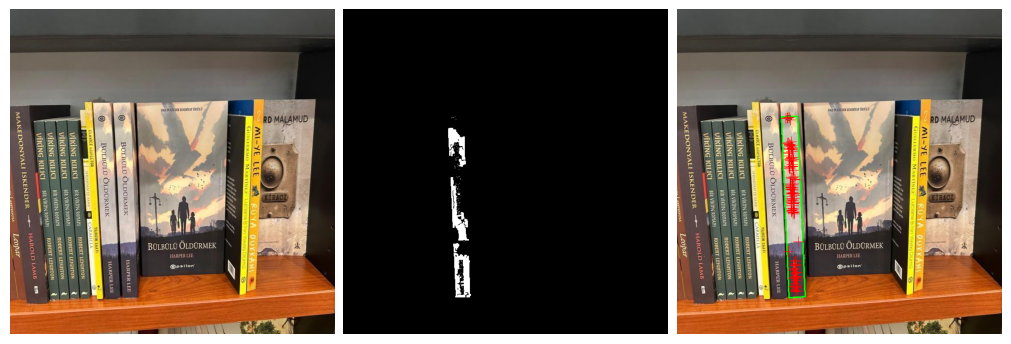

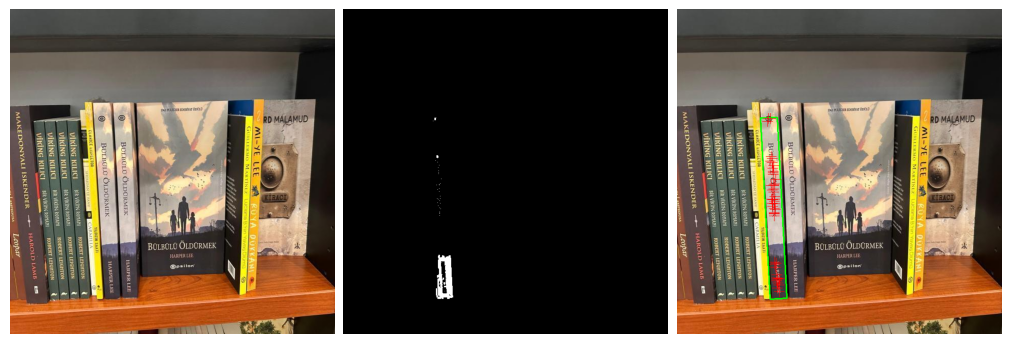

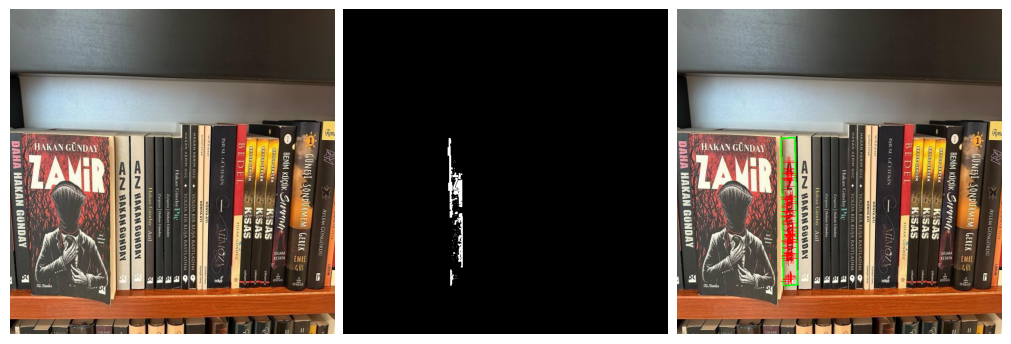

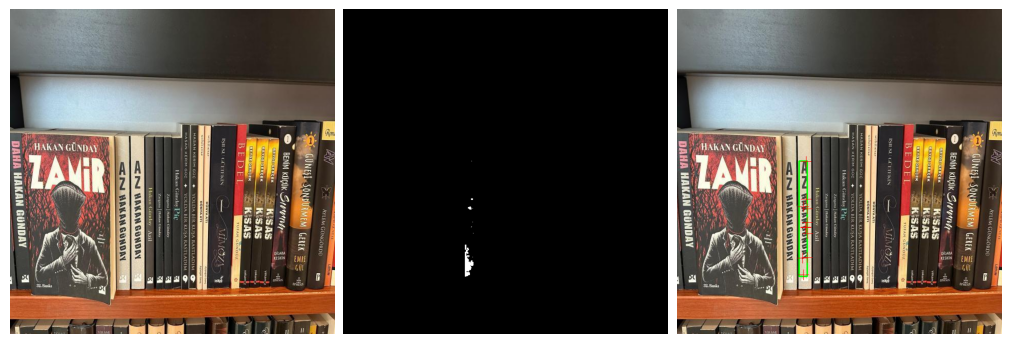

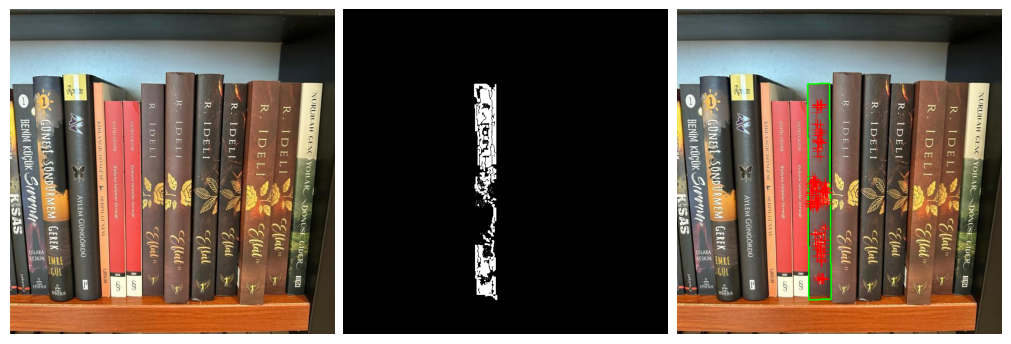

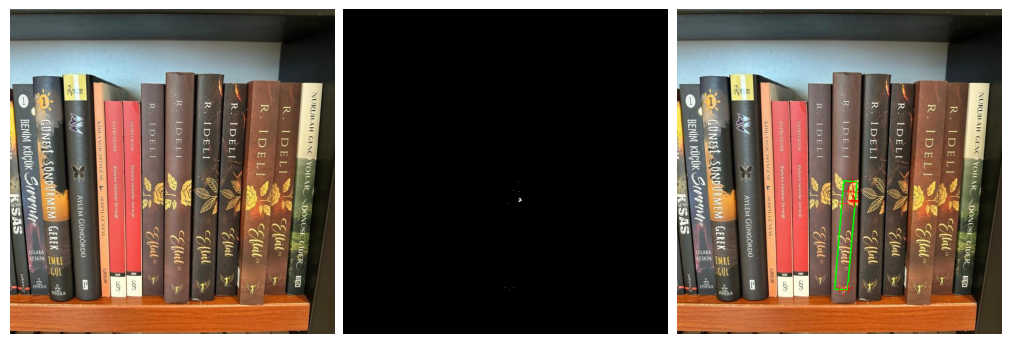

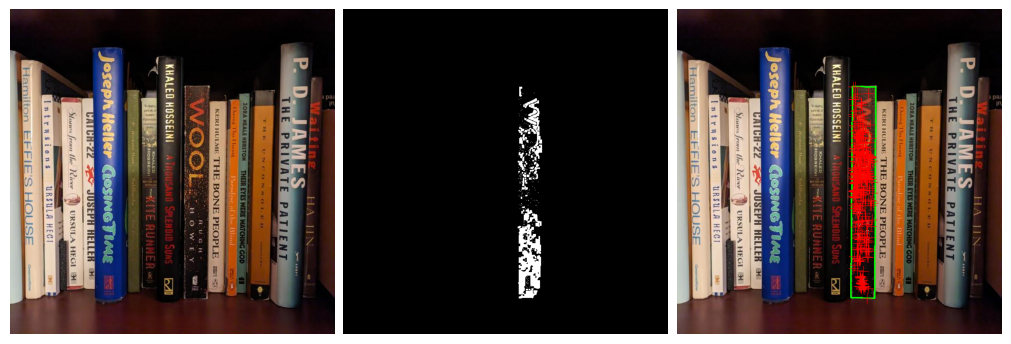

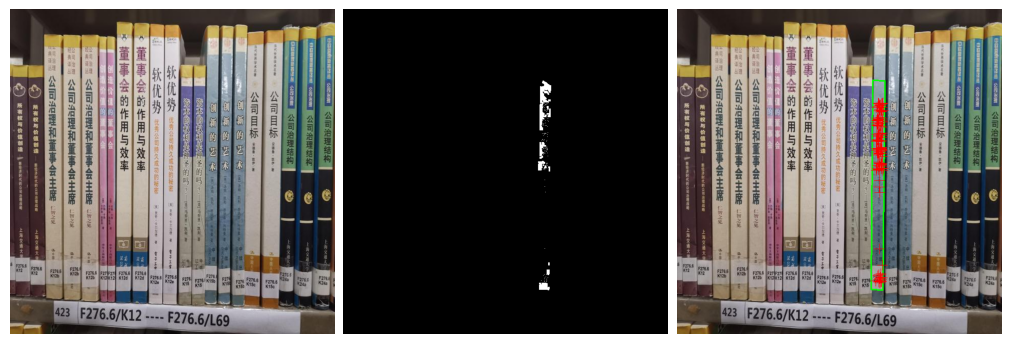

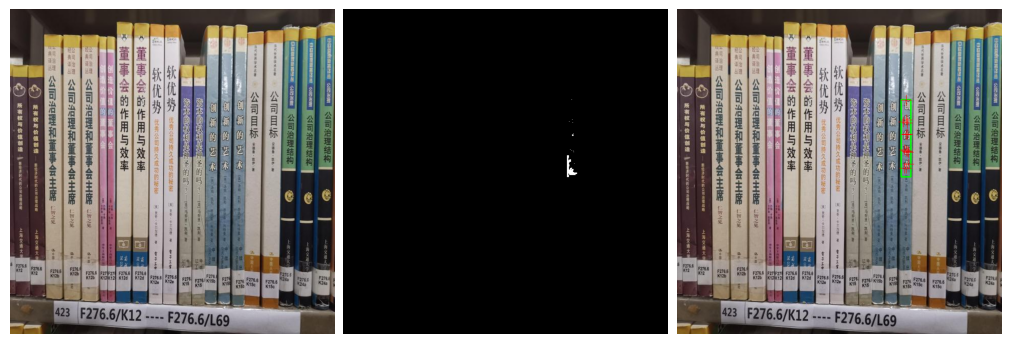

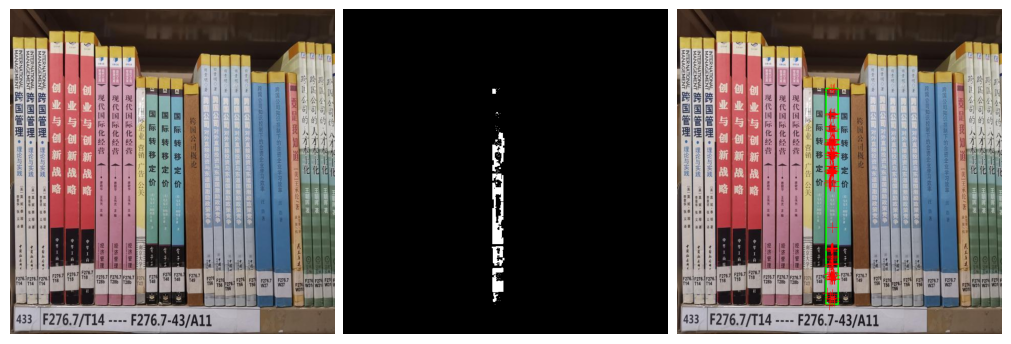

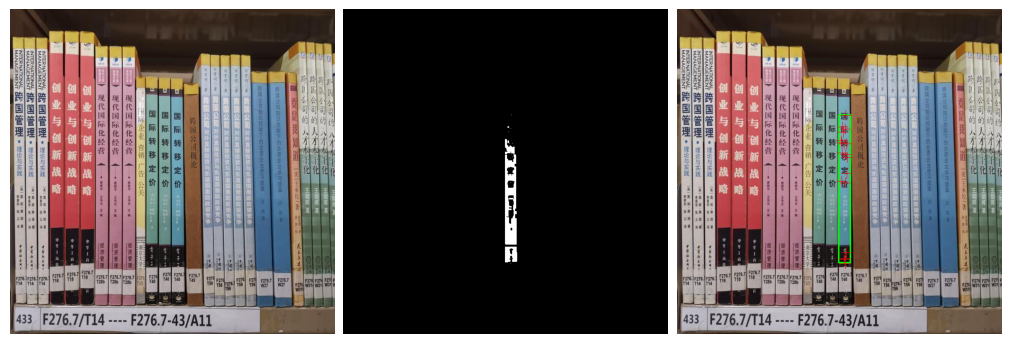

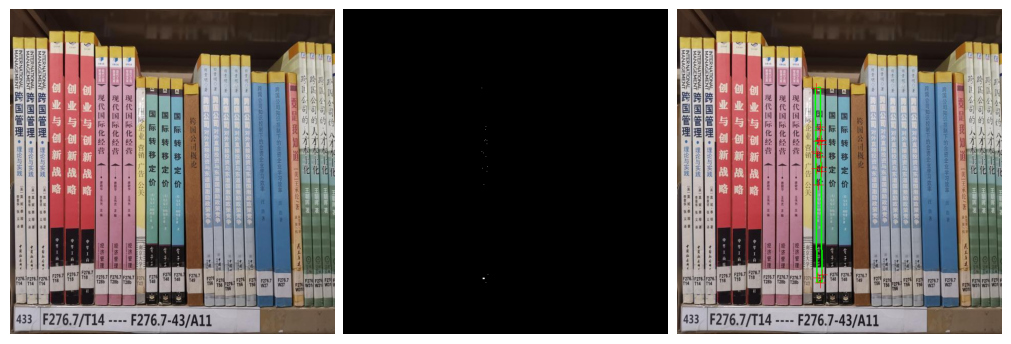

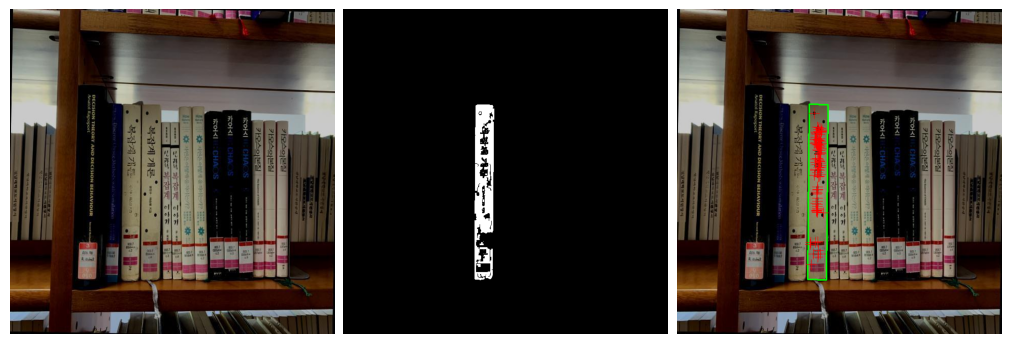

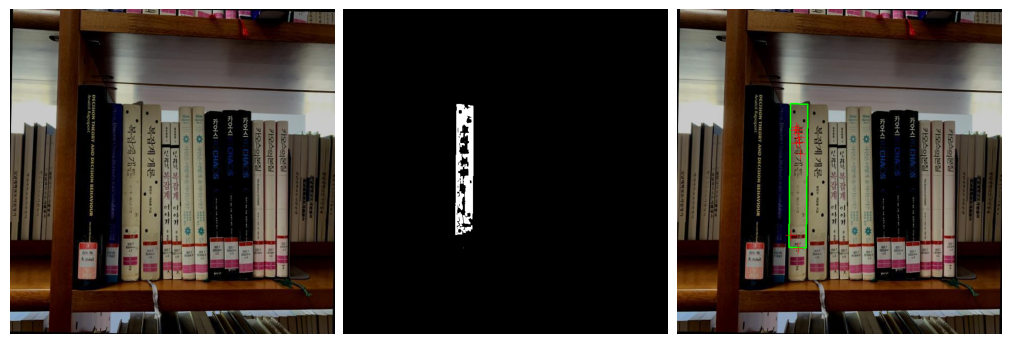

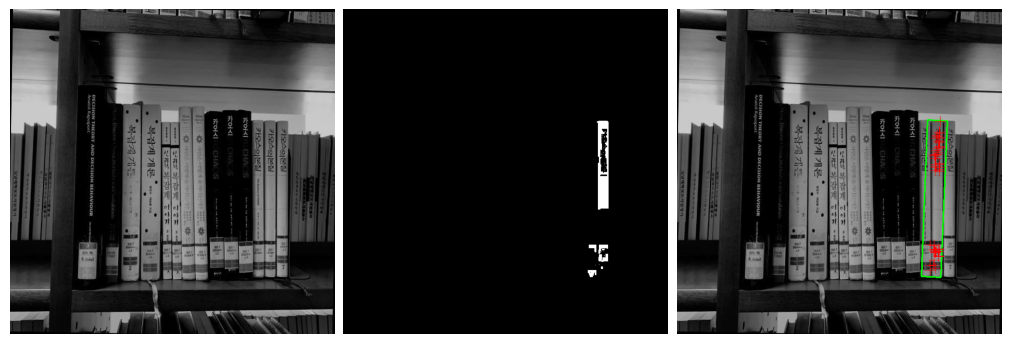

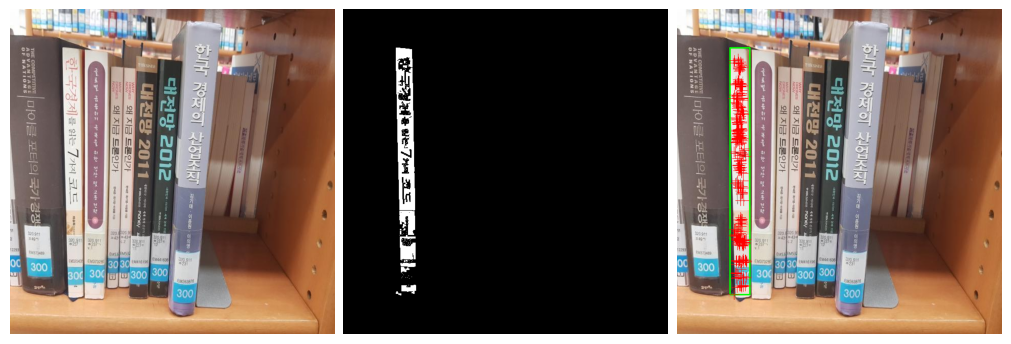

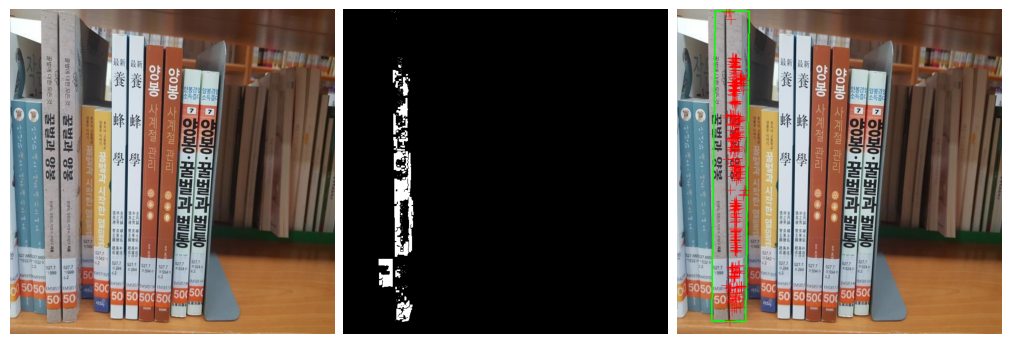

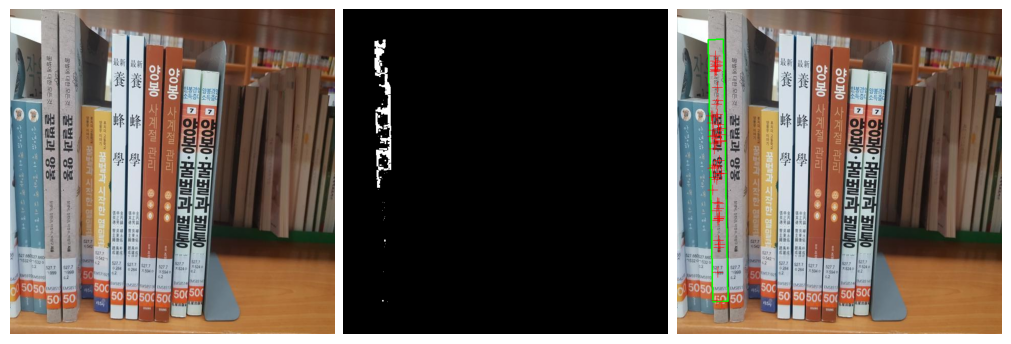

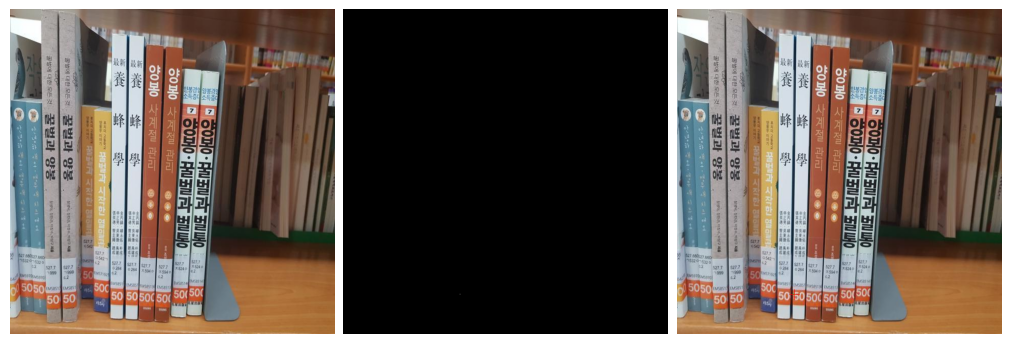

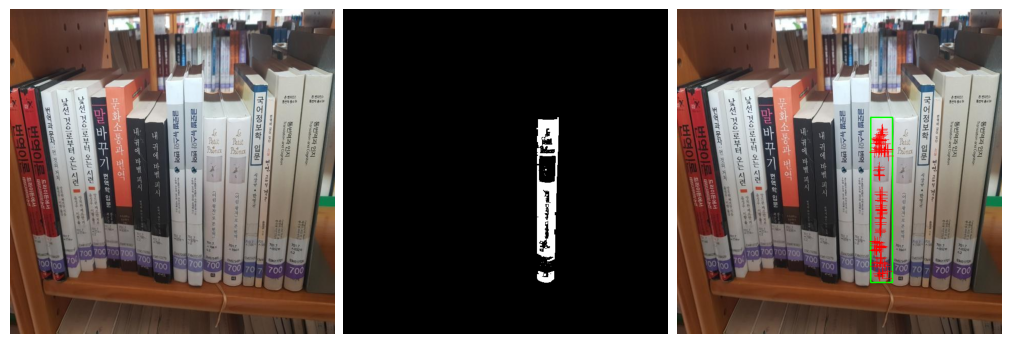

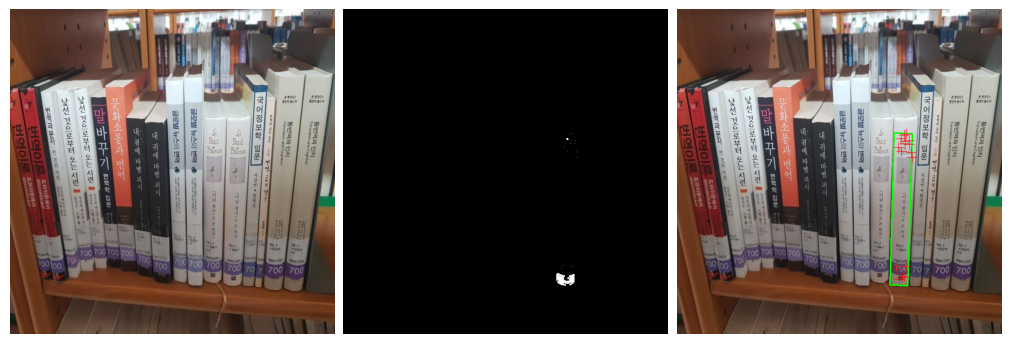

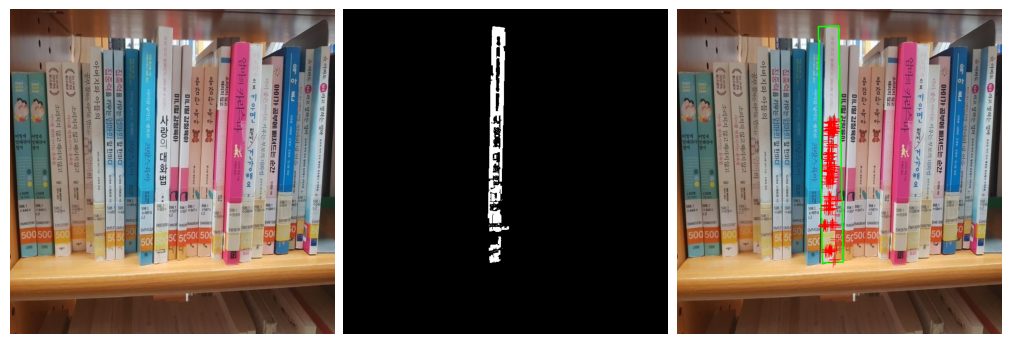

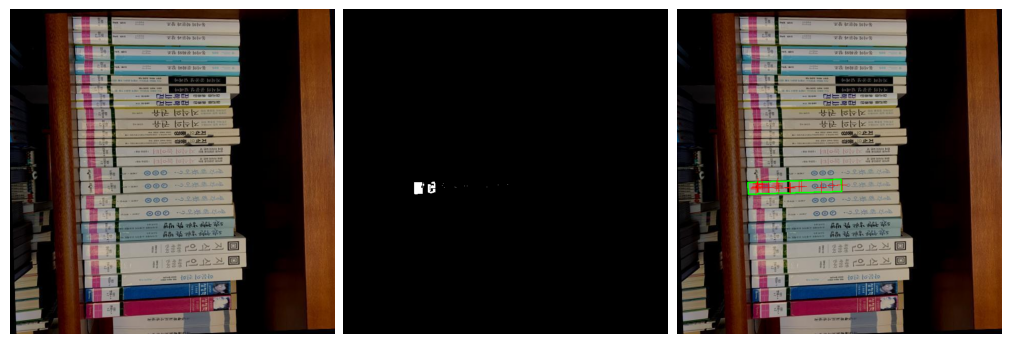

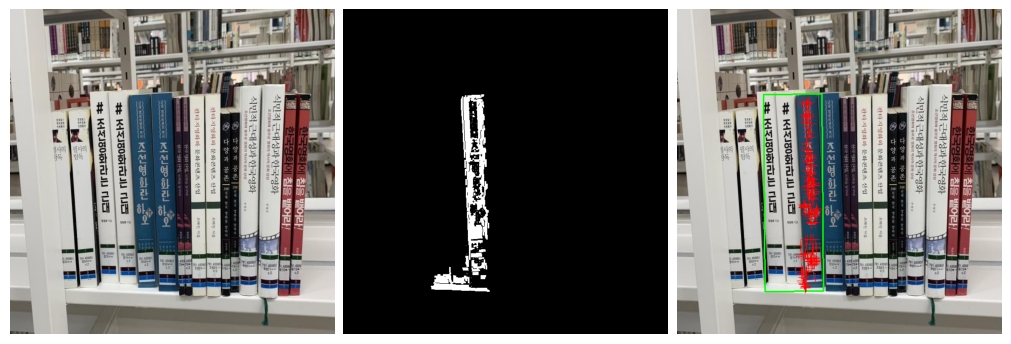

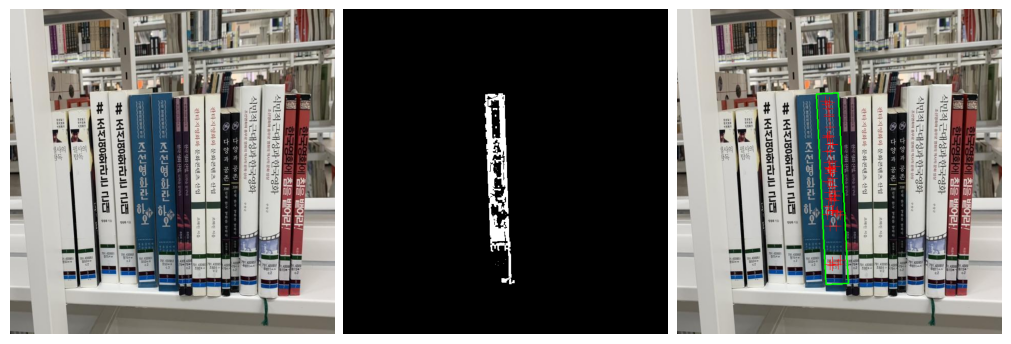

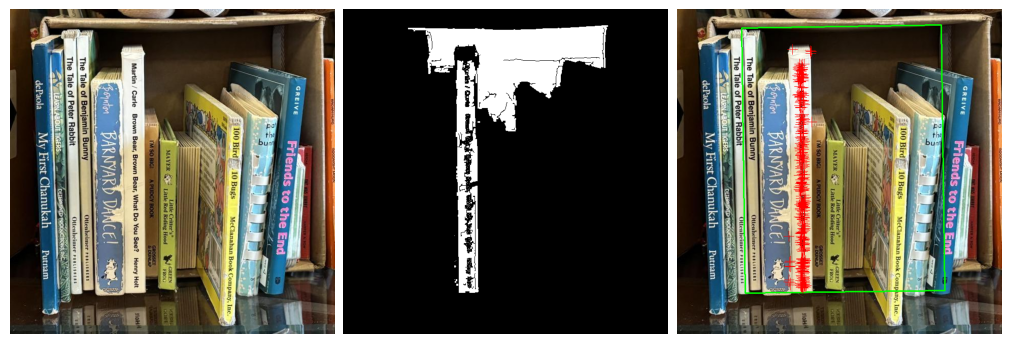

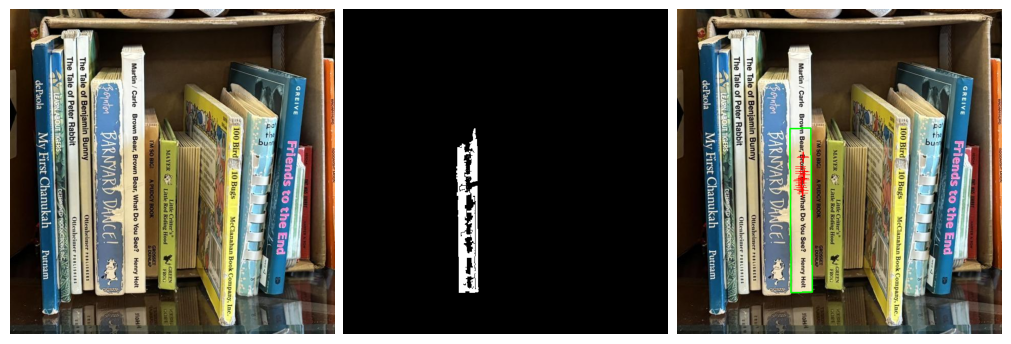

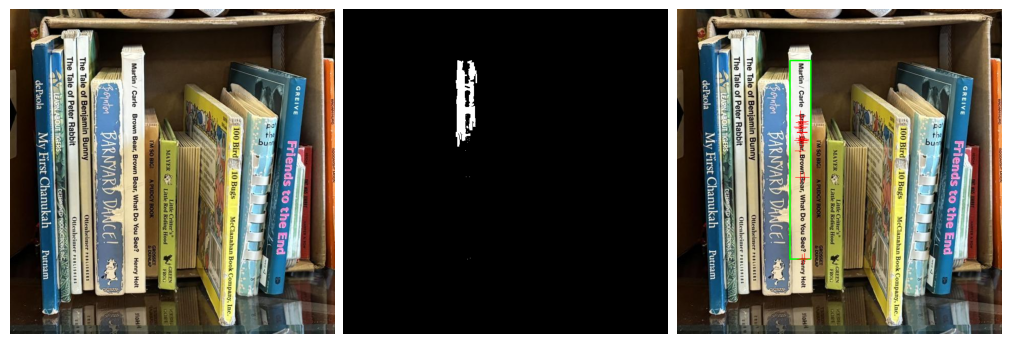


---- end experiment ----



In [660]:
for exp_conf in params:
    experiment(exp_conf)
    print("")
    print("---- end experiment ----")
    print("")